# 3D Image Segmentation

### Imports

In [1]:
import os
import cc3d
import pydicom
import numpy as np
import SimpleITK as sitk
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from dataclasses import dataclass
from typing import List, Dict, Tuple
from skimage.filters import threshold_otsu
from skimage.measure import label as sk_label, regionprops
from scipy.spatial.distance import cdist, directed_hausdorff
from scipy.ndimage import binary_fill_holes, binary_opening, binary_closing, label as cc_label, generate_binary_structure

### I/O DICOM function

In [2]:
def load_ct_volume(folder_path: str):
    """
    Load a DICOM CT series from a folder into a SimpleITK Image and a NumPy array in Hounsfield Units (HU).
    """
    reader = sitk.ImageSeriesReader()
    # Find all series IDs in the given folder
    series_ids = reader.GetGDCMSeriesIDs(folder_path)
    assert series_ids, f"No DICOM series found in {folder_path}"
    # Get sorted file names for the first series
    file_names = reader.GetGDCMSeriesFileNames(folder_path, series_ids[0])
    reader.SetFileNames(file_names)
    # Read the entire volume as a SimpleITK Image
    img = reader.Execute()
    # Convert to NumPy array with shape (slices, height, width)
    arr = sitk.GetArrayFromImage(img)
    # Retrieve and apply rescale slope/intercept if present to convert raw pixel values to HU
    slope = float(img.GetMetaData('0028|1053')) if img.HasMetaDataKey('0028|1053') else 1.0
    intercept = float(img.GetMetaData('0028|1052')) if img.HasMetaDataKey('0028|1052') else 0.0
    arr = arr * slope + intercept
    # Print basic info about the loaded volume
    print(f"[IO-CT] {os.path.basename(folder_path)} → shape={arr.shape}, spacing={img.GetSpacing()}")
    return img, arr


def load_segmentation(dcm_path: str, ref_img: sitk.Image):
    """
    Load a DICOM segmentation and align its frames into a 3D mask
    matching the reference CT image geometry.
    Returns:
      - seg: SimpleITK Image of the segmentation (with metadata)
      - full_mask: NumPy array (depth, height, width) of uint8 0/1
    """
    # Read segmentation image in SimpleITK and extract pixel arrays
    seg = sitk.ReadImage(dcm_path)
    frames = sitk.GetArrayFromImage(seg)  # shape: (num_frames, H, W)

    ds = pydicom.dcmread(dcm_path)
    # Get the CT volume dimensions: width=X, height=Y, depth=Z
    depth = ref_img.GetSize()[2]
    height = ref_img.GetSize()[1]
    width  = ref_img.GetSize()[0]

    # Initialize an empty 3D mask
    full_mask = np.zeros((depth, height, width), dtype=np.uint8)

    # Map each 2D segmentation frame into the correct Z-slice of the CT volume
    for idx, frame_meta in enumerate(ds.PerFrameFunctionalGroupsSequence):
        # Physical Z position of this mask frame
        zpos = float(frame_meta.PlanePositionSequence[0].ImagePositionPatient[2])
        # Find the matching slice index in the CT volume by comparing Z coordinates
        slice_indices = [
            i for i in range(depth)
            if np.isclose(ref_img.TransformIndexToPhysicalPoint((0, 0, i))[2], zpos)
        ]
        if not slice_indices:
            raise ValueError(f"No slice match for Z={zpos:.3f} in segmentation frame {idx}")
        iz = slice_indices[0]
        
        # Place the binary mask (frame > 0) in the 3D volume
        full_mask[iz] = (frames[idx] > 0).astype(np.uint8)

    return seg, full_mask

### Compute bounding box and centroid

In [3]:
def compute_all_rois(mask: np.ndarray, margin: int, ref_vol: np.ndarray) -> List[Dict[str, Tuple]]:
    """
    Identify and describe all connected components in a binary mask.

    For each component:
      - Compute its 3D bounding box (inclusive indices), expanded by a fixed margin.
      - Compute its centroid coordinates.
      - Verify that the bounding-box faces and the centroid lie on actual mask voxels.
      - Overlay the bounding box and centroid on the corresponding slice of the reference volume for visual inspection.

    Returns:
        A list of dictionaries, each with:
          'label'     : integer ID of the component
          'bbox'      : ((z0, z1), (y0, y1), (x0, x1)) inclusive voxel index bounds
          'centroid'  : (cz, cy, cx) integer voxel coordinates of the centroid
    """
    results = []
    # 1) Label each connected region in the mask (3D)
    labeled_mask = sk_label(mask)

    # 2) Iterate through each detected region
    for region in regionprops(labeled_mask):
        label_id = region.label
        # Skip any empty regions (shouldn't occur, but safe)
        if region.area == 0:
            continue

        # region.bbox gives (min_z, min_y, min_x, max_z_excl, max_y_excl, max_x_excl)
        min_z, min_y, min_x, max_z_excl, max_y_excl, max_x_excl = region.bbox
        # Convert the exclusive max indices to inclusive
        max_z = max_z_excl - 1
        max_y = max_y_excl - 1
        max_x = max_x_excl - 1

        # Compute the integer centroid coordinates (z, y, x)
        cz, cy, cx = map(lambda v: int(round(v)), region.centroid)

        # 3) Expand the bounding box by 'margin' voxels, clipped to volume limits
        z0 = max(0,     min_z - margin)
        z1 = min(mask.shape[0] - 1, max_z + margin)
        y0 = max(0,     min_y - margin)
        y1 = min(mask.shape[1] - 1, max_y + margin)
        x0 = max(0,     min_x - margin)
        x1 = min(mask.shape[2] - 1, max_x + margin)
        bbox = ((z0, z1), (y0, y1), (x0, x1))

        # 4) Consistency checks to ensure bbox faces and centroid are valid mask locations
        assert mask[min_z, :, :].any(), f"No mask voxels at min_z={min_z} for region {label_id}"
        assert mask[max_z, :, :].any(), f"No mask voxels at max_z={max_z} for region {label_id}"
        assert mask[:, min_y, :].any(), f"No mask voxels at min_y={min_y} for region {label_id}"
        assert mask[:, max_y, :].any(), f"No mask voxels at max_y={max_y} for region {label_id}"
        assert mask[:, :, min_x].any(), f"No mask voxels at min_x={min_x} for region {label_id}"
        assert mask[:, :, max_x].any(), f"No mask voxels at max_x={max_x} for region {label_id}"
        assert mask[cz, cy, cx] == 1,   f"Centroid {(cz, cy, cx)} is not within the mask for region {label_id}"

        # 5) Visualize the component on the centroid slice for debugging
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(ref_vol[cz], cmap='gray')             # display CT slice
        ax.contour(mask[cz], colors='g', linewidths=1)   # overlay mask contour (green)
        # draw expanded bounding box (red rectangle)
        rect = patches.Rectangle(
            (x0, y0),
            x1 - x0,
            y1 - y0,
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
        # mark centroid (red dot)
        ax.plot(cx, cy, 'ro')
        ax.set_title(f"Region {label_id} @ slice {cz}")
        ax.axis('off')
        plt.show()

        # 6) Record region properties
        results.append({
            'label': label_id,
            'bbox': bbox,
            'centroid': (cz, cy, cx)
        })

    return results

## TO IMPROVE

### Region growing with ROI enforcement

In [4]:
class RegionGrowing3D:
    def __init__(self, volume: np.ndarray, lower: int, upper: int, roi: Tuple[Tuple[int]] = None, debug: bool = False):
        """
        Region growing algorithm for 3D CT volumes using intensity thresholding and optional ROI.

        Args:
            volume (np.ndarray): 3D CT volume in Hounsfield Units (Z, Y, X).
            lower (int): Lower HU threshold for voxel inclusion.
            upper (int): Upper HU threshold for voxel inclusion.
            roi (tuple): Optional bounding box ((z0,z1), (y0,y1), (x0,x1)) to constrain growth.
            debug (bool): If True, prints debug information.
        """
        self.vol = volume
        self.lower = lower
        self.upper = upper
        self.roi = roi
        self.debug = debug
        self.shape = volume.shape

    def _in_roi(self, z: int, y: int, x: int) -> bool:
        """
        Check if voxel (z, y, x) is within the ROI (if specified).
        """
        if self.roi is None:
            return True
        (z0, z1), (y0, y1), (x0, x1) = self.roi
        return z0 <= z <= z1 and y0 <= y <= y1 and x0 <= x <= x1

    def _is_valid(self, z: int, y: int, x: int, visited: np.ndarray) -> bool:
        """
        Check if voxel is inside bounds, not yet visited, and within ROI.
        """
        return (
            0 <= z < self.shape[0] and
            0 <= y < self.shape[1] and
            0 <= x < self.shape[2] and
            not visited[z, y, x] and
            self._in_roi(z, y, x)
        )

    def segment(self, seed: Tuple[int, int, int]):
        """
        Perform region growing starting from the given seed.

        Args:
            seed (tuple): Starting point (z, y, x) in voxel indices.

        Returns:
            mask (np.ndarray): Binary mask (uint8) of the segmented region.
            stats (dict): Dictionary with voxel counters and rejection reasons.
        """
        mask = np.zeros_like(self.vol, dtype=bool)
        queue = deque([seed])

        stats = {
            'queued': 1,
            'accepted': 0,
            'roi_reject': 0,
            'int_reject': 0
        }

        # Define 26-connected neighborhood
        neighbors = [
            (dz, dy, dx)
            for dz in [-1, 0, 1]
            for dy in [-1, 0, 1]
            for dx in [-1, 0, 1]
            if not (dz == dy == dx == 0)
        ]

        while queue:
            z, y, x = queue.popleft()

            # Skip if already visited
            if mask[z, y, x]:
                continue

            # Skip if out of ROI
            if not self._in_roi(z, y, x):
                stats['roi_reject'] += 1
                continue

            # Check intensity range
            hu = self.vol[z, y, x]
            if not (self.lower <= hu <= self.upper):
                stats['int_reject'] += 1
                continue

            # Accept voxel
            mask[z, y, x] = True
            stats['accepted'] += 1

            # Enqueue neighbors
            for dz, dy, dx in neighbors:
                nz, ny, nx = z + dz, y + dy, x + dx
                if self._is_valid(nz, ny, nx, mask):
                    queue.append((nz, ny, nx))
                    stats['queued'] += 1

        mask_uint8 = mask.astype(np.uint8)

        if self.debug:
            print("=== RegionGrowing3D stats ===")
            print(f"  Seed: {seed}")
            print(f"  Queued voxels:    {stats['queued']}")
            print(f"  Accepted voxels:  {stats['accepted']}")
            print(f"  ROI rejections:   {stats['roi_reject']}")
            print(f"  Intensity reject: {stats['int_reject']}")
            print(f"  Final mask size:  {mask_uint8.sum()} voxels")
            print("=============================")

        return mask_uint8, stats

### Post‐processing

In [5]:
def clean_mask(mask: np.ndarray, min_vox: int) -> np.ndarray:
    """
    Post-processes a binary mask:
      - fills small holes,
      - removes noise with morphological opening/closing,
      - keeps only connected components above a minimum voxel size.

    Args:
        mask (np.ndarray): Binary mask (0/1) to clean.
        min_vox (int): Minimum number of voxels to retain a component.

    Returns:
        np.ndarray: Cleaned binary mask (0/1).
    """
    struct = generate_binary_structure(rank=3, connectivity=2)

    # Fill internal holes
    mask_filled = binary_fill_holes(mask)

    # Remove small objects and close gaps
    mask_opened = binary_opening(mask_filled, structure=struct)
    mask_closed = binary_closing(mask_opened, structure=struct)

    # Label connected components
    labeled, num = cc_label(mask_closed)
    output = np.zeros_like(mask, dtype=np.uint8)

    # Keep only large enough components
    for label_id in range(1, num + 1):
        component = (labeled == label_id)
        if component.sum() >= min_vox:
            output[component] = 1

    return output


### Classe per le metriche

In [6]:
class EvalMetrics:
    @staticmethod
    def dice(gt: np.ndarray, pred: np.ndarray) -> float:
        """
        Computes the Dice coefficient between ground truth and predicted mask.
        Dice = 2 * |A ∩ B| / (|A| + |B|)
        """
        inter = np.logical_and(gt, pred).sum()
        total = gt.sum() + pred.sum()
        return 2 * inter / total if total > 0 else 0.0

    @staticmethod
    def jaccard(gt: np.ndarray, pred: np.ndarray) -> float:
        """
        Computes the Jaccard index (Intersection over Union).
        Jaccard = |A ∩ B| / |A ∪ B|
        """
        inter = np.logical_and(gt, pred).sum()
        union = np.logical_or(gt, pred).sum()
        return inter / union if union > 0 else 0.0

    @staticmethod
    def precision(gt: np.ndarray, pred: np.ndarray) -> float:
        """
        Computes the precision: TP / (TP + FP)
        Measures how many predicted positives are correct.
        """
        tp = np.logical_and(gt, pred).sum()
        fp = np.logical_and(~gt, pred).sum()
        return tp / (tp + fp) if (tp + fp) > 0 else 0.0

    @staticmethod
    def recall(gt: np.ndarray, pred: np.ndarray) -> float:
        """
        Computes the recall (sensitivity): TP / (TP + FN)
        Measures how many actual positives were detected.
        """
        tp = np.logical_and(gt, pred).sum()
        fn = np.logical_and(gt, ~pred).sum()
        return tp / (tp + fn) if (tp + fn) > 0 else 0.0

    @staticmethod
    def hausdorff(gt: np.ndarray, pred: np.ndarray, spacing: tuple) -> float:
        """
        Computes the bidirectional Hausdorff Distance in mm.
        Measures the maximum distance between surfaces of GT and prediction.
        """
        gt_pts   = np.argwhere(gt)
        pred_pts = np.argwhere(pred)
        gt_phys   = gt_pts   * np.array(spacing)[::-1]  # convert to mm (z, y, x)
        pred_phys = pred_pts * np.array(spacing)[::-1]
        d1 = directed_hausdorff(gt_phys, pred_phys)[0]
        d2 = directed_hausdorff(pred_phys, gt_phys)[0]
        return max(d1, d2)

    @staticmethod
    def vol_diff(gt: np.ndarray, pred: np.ndarray, spacing: tuple) -> float:
        """
        Computes the absolute difference in volume (cm³) between GT and prediction.
        """
        voxel_vol = np.prod(spacing)  # mm³
        n_gt   = int(gt.sum())
        n_pred = int(pred.sum())
        return abs(n_pred - n_gt) * voxel_vol / 1000  # convert to cm³

    @staticmethod
    def assd(gt: np.ndarray, pred: np.ndarray, spacing: Tuple[float]) -> float:
        """
        Computes the Average Symmetric Surface Distance (ASSD) in mm.
        Measures the average distance between surfaces of GT and prediction.
        """
        gt_pts   = np.argwhere(gt)   * np.array(spacing)[::-1]
        pred_pts = np.argwhere(pred) * np.array(spacing)[::-1]
        if gt_pts.size == 0 or pred_pts.size == 0:
            return float('nan')
        d1 = cdist(gt_pts, pred_pts).min(axis=1).mean()
        d2 = cdist(pred_pts, gt_pts).min(axis=1).mean()
        return 0.5 * (d1 + d2)

    @staticmethod
    def surface_dice(gt: np.ndarray, pred: np.ndarray, spacing: Tuple[float], tol_mm: float) -> float:
        """
        Computes the Surface Dice metric within a tolerance threshold (in mm).
        Measures the fraction of surface points that are within tol_mm of the other surface.
        """
        gt_pts   = np.argwhere(gt)   * np.array(spacing)[::-1]
        pred_pts = np.argwhere(pred) * np.array(spacing)[::-1]
        if gt_pts.size == 0 or pred_pts.size == 0:
            return float('nan')
        D = cdist(gt_pts, pred_pts)
        n_gt_in   = (D.min(axis=1) <= tol_mm).sum()
        n_pred_in = (D.min(axis=0) <= tol_mm).sum()
        return (n_gt_in + n_pred_in) / (len(gt_pts) + len(pred_pts))

### Visualizzazione slice con overlay

In [7]:
def overlay_slice(ct: np.ndarray, gt: np.ndarray, auto: np.ndarray, z: int, bbox: Tuple[int]):
    """
    Visualize a single axial CT slice with overlays of:
    - Ground truth (GT) mask in green
    - Automatically segmented mask in red
    - Bounding box around the ROI in yellow

    Args:
        ct (np.ndarray): 3D CT volume (Z, Y, X).
        gt (np.ndarray): Ground truth binary mask (same shape as ct).
        auto (np.ndarray): Predicted/automatic segmentation mask.
        z (int): Slice index to visualize.
        bbox (Tuple): Bounding box as ((min_z,max_z), (min_y,max_y), (min_x,max_x)).
    """
    (min_z, max_z), (min_y, max_y), (min_x, max_x) = bbox

    # Create a new figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # Display the CT slice in grayscale
    ax.imshow(ct[z], cmap='gray')

    # Overlay the ground truth contour (green)
    if np.any(gt[z]):
        ax.contour(gt[z], colors='g', linewidths=1)

    # Overlay the predicted segmentation contour (red)
    if np.any(auto[z]):
        ax.contour(auto[z], colors='r', linewidths=1)

    # Draw the bounding box (projected to 2D) in yellow
    width = max_x - min_x
    height = max_y - min_y
    rect = patches.Rectangle(
        (min_x, min_y),   # Top-left corner (x, y)
        width,
        height,
        edgecolor='yellow',
        facecolor='none',
        linewidth=2
    )
    ax.add_patch(rect)

    # Finalize the visualization
    ax.set_title(f"Slice {z}")
    ax.axis('off')
    plt.show()


def overlay_errors(ct: np.ndarray, gt: np.ndarray, auto: np.ndarray, z: int):
    """
    Visualize segmentation errors on a single CT slice:
    - False positives (FP) in red
    - False negatives (FN) in blue

    Args:
        ct (np.ndarray): 3D CT volume (Z, Y, X).
        gt (np.ndarray): Ground truth binary mask.
        auto (np.ndarray): Predicted segmentation binary mask.
        z (int): Index of the slice to visualize.
    """
    # Compute error masks
    fp = np.logical_and(~gt, auto)  # False positives: auto = 1, gt = 0
    fn = np.logical_and(gt, ~auto)  # False negatives: auto = 0, gt = 1

    # Create the figure
    plt.figure(figsize=(5, 5))

    # Show the CT slice in background
    plt.imshow(ct[z], cmap='gray')

    # Overlay FP in red with transparency
    plt.imshow(fp[z], cmap='Reds', alpha=0.5, vmin=0, vmax=1)

    # Overlay FN in blue with transparency
    plt.imshow(fn[z], cmap='Blues', alpha=0.5, vmin=0, vmax=1)

    # Add title and remove axes
    plt.title(f"Errors slice {z}: Red = FP, Blue = FN")
    plt.axis('off')
    plt.show()

## MAIN

### Load

In [8]:
@dataclass
class Config:
    dicom_base: str = "../dataset"                              # Base directory containing patient DICOM subfolders
    patient_ref: str = "10_AP_Ax2.50mm"                         # Identifier (folder name) for the reference CT series to load
    seg_filename: str = "10_AP_Ax2.50mm_ManualROI_Tumor.dcm"    # Filename of the manual tumor mask (DICOM) corresponding to the reference series
    intensity_lower: int = -50                                  # Intensity window lower bound (in Hounsfield Units) for initial segmentation
    intensity_upper: int = 150                                  # Intensity window upper bound (in Hounsfield Units) for initial segmentation
    roi_margin: int = 5                                         # Margin (in voxels) to expand the automatically computed bounding box around the tumor
    min_voxels: int = 500                                       # Minimum connected‐component size (in voxels) to keep during post‐processing
    threshold_margin: int = 20                                  # Margin (in HU) applied around the Otsu‐computed threshold to allow some flexibility
    use_adaptive_threshold: bool = True                         # If True, compute a local Otsu threshold within each ROI; otherwise use fixed intensity bounds
    debug: bool = True                                          # If True, print intermediate debug information (thresholds, voxel counts, etc.)

# Instantiate the configuration with dataset paths and parameters
cfg = Config()


# 1) Load the CT series from DICOM files and convert pixel values to Hounsfield Units (HU)
#    - ref_ct: SimpleITK Image object (needed for metadata like spacing)
#    - ref_vol: NumPy array of shape (slices, height, width) with HU values
ref_ct, ref_vol = load_ct_volume(os.path.join(cfg.dicom_base, cfg.patient_ref))


# 3) Load the manual tumor mask and align it to the (now denoised) CT volume
#    - seg_img: SimpleITK Image of the segmentation (retains per-frame metadata)
#    - ref_mask: 3D NumPy array (depth, height, width) of uint8 values (0 for background, 1 for tumor)
seg_img, ref_mask = load_segmentation(
    os.path.join(cfg.dicom_base, cfg.seg_filename),
    ref_ct
)

[IO-CT] 10_AP_Ax2.50mm → shape=(207, 512, 512), spacing=(0.78125, 0.78125, 2.5)


### ROI and centroid

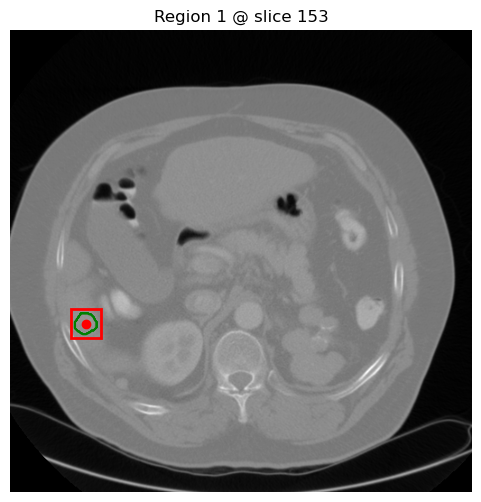

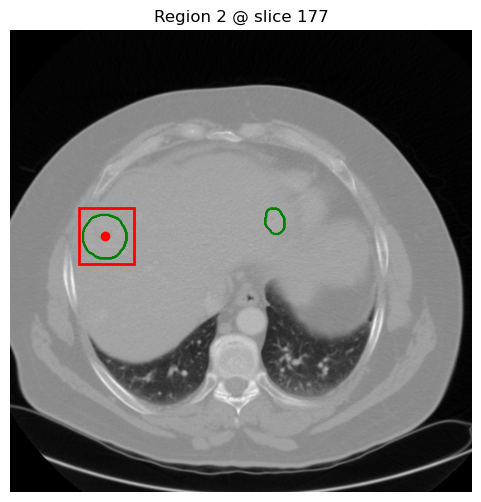

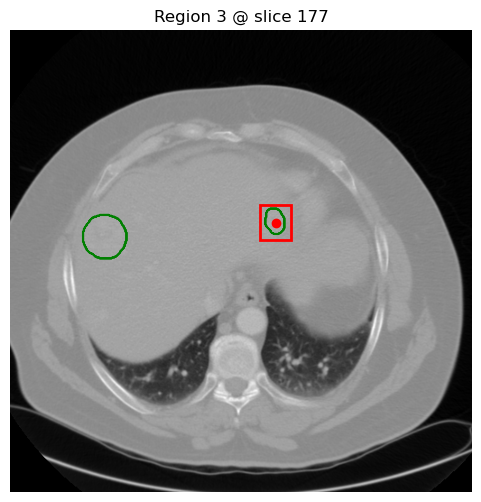

Component 1: bbox=((147, 158), (309, 341), (67, 100)), centroid=(153, 325, 84)
Component 2: bbox=((166, 188), (197, 259), (76, 137)), centroid=(177, 228, 105)
Component 3: bbox=((171, 183), (193, 232), (277, 311)), centroid=(177, 213, 294)


In [9]:
# Compute all regions of interest (ROIs) in the reference mask:
# - Finds connected components, computes their bounding boxes (with margin), and centroids
rois = compute_all_rois(ref_mask, cfg.roi_margin, ref_vol)

# Iterate over each ROI entry and print its label, bounding box, and centroid coordinates
for entry in rois:
    print(f"Component {entry['label']}: bbox={entry['bbox']}, centroid={entry['centroid']}")

### Preprocessing

In [10]:
# 1) Denoising 3D con filtro Gaussiano
sigma_mm = 1.0
ref_ct = sitk.DiscreteGaussian(ref_ct, variance=sigma_mm**2)

# 2) Convert denoised image to NumPy (still in HU because we smoothed after HU conversion)
ref_vol = sitk.GetArrayFromImage(ref_ct)

# 3) HU Clipping per mantenere valori in range tessuti molli [-200, 300] HU
ref_vol = np.clip(ref_vol, -200, 300)

# Debug
if cfg.debug:
    print(f"[Preprocessing] Denoising: sigma={sigma_mm}")
    print(f"[Preprocessing] HU clipping: range=[-200, 300]")

[Preprocessing] Denoising: sigma=1.0
[Preprocessing] HU clipping: range=[-200, 300]


### Compute segmentation

In [11]:
results = []
for entry in rois:
    comp_id = entry['label']
    (min_z, max_z), (min_y, max_y), (min_x, max_x) = entry['bbox']
    bbox = ((min_z, max_z), (min_y, max_y), (min_x, max_x))

    # 1) Slicing del sub-volume (utile per soglia adattiva)
    subvol = ref_vol[min_z:max_z+1, min_y:max_y+1, min_x:max_x+1]

    # ) Seed point globale
    cz, cy, cx = entry['centroid']

    # ) Calcolo soglie (in HU o normalizzati, a seconda del preprocessing)
    if cfg.use_adaptive_threshold:
        thr = threshold_otsu(subvol)
        thr = np.clip(thr, cfg.intensity_lower, cfg.intensity_upper)

        # Calcola il valore HU al seed
        seed_val = ref_vol[cz, cy, cx]

        # Forza l'inclusione del seed nelle soglie
        lower = min(thr - cfg.threshold_margin, seed_val)
        upper = max(thr + cfg.threshold_margin, seed_val)

        # Debug
        if cfg.debug:
            print(f"  Seed HU value: {seed_val:.2f}")
    else:
        lower = cfg.intensity_lower
        upper = cfg.intensity_upper

    
    

    if cfg.debug:
        val_at_seed = ref_vol[cz, cy, cx]
        print(f"\n--- Component {comp_id} ---")
        print(f"  Bounding Box: Z[{min_z},{max_z}], Y[{min_y},{max_y}], X[{min_x},{max_x}]")
        print(f"  Seed: (z={cz}, y={cy}, x={cx})")
        print(f"  Value at seed: {val_at_seed:.2f} HU")
        print(f"  Thresholds: lower={lower}, upper={upper}")
        print(f"  Seed value: {seed_val:.2f} | Otsu: {thr:.2f} | Final thresholds: [{lower:.1f}, {upper:.1f}]")

    # 4) Region Growing limitato alla ROI
    rg = RegionGrowing3D(
        volume=ref_vol,
        lower=lower,
        upper=upper,
        roi=bbox,
        debug=cfg.debug
    )
    full_mask, stats = rg.segment(seed=(cz, cy, cx))
    auto_raw = full_mask.astype(np.uint8)

    auto = cc3d.dust(auto_raw, threshold=cfg.min_voxels, connectivity=26)

    if cfg.debug:
        print(f"  Raw voxels (before cc): {auto_raw.sum()}")
        print(f"  Clean voxels (after cc): {auto.sum()}")
        print(f"  RegionGrowing accepted: {stats['accepted']} voxels")

    results.append({
        'label':      comp_id,
        'roi':        bbox,
        'raw_mask':   auto_raw,
        'final_mask': auto
    })


  Seed HU value: 94.00

--- Component 1 ---
  Bounding Box: Z[147,158], Y[309,341], X[67,100]
  Seed: (z=153, y=325, x=84)
  Value at seed: 94.00 HU
  Thresholds: lower=-10, upper=94
  Seed value: 94.00 | Otsu: 10.00 | Final thresholds: [-10.0, 94.0]
=== RegionGrowing3D stats ===
  Seed: (153, 325, 84)
  Queued voxels:    124218
  Accepted voxels:  9748
  ROI rejections:   0
  Intensity reject: 15451
  Final mask size:  9748 voxels
  Raw voxels (before cc): 9748
  Clean voxels (after cc): 9748
  RegionGrowing accepted: 9748 voxels
  Seed HU value: 56.00

--- Component 2 ---
  Bounding Box: Z[166,188], Y[197,259], X[76,137]
  Seed: (z=177, y=228, x=105)
  Value at seed: 56.00 HU
  Thresholds: lower=-48, upper=56
  Seed value: 56.00 | Otsu: -28.00 | Final thresholds: [-48.0, 56.0]
=== RegionGrowing3D stats ===
  Seed: (177, 228, 105)
  Queued voxels:    579229
  Accepted voxels:  40045
  ROI rejections:   0
  Intensity reject: 194411
  Final mask size:  40045 voxels
  Raw voxels (before 

Dice=0.0593, Jaccard=0.0306, Precision=0.0373, Recall=0.1120, Hausdorff=25.88 mm, VolDiff=69.96 cm³

ASSD=5.98 mm, SurfaceDice@2mm=0.113


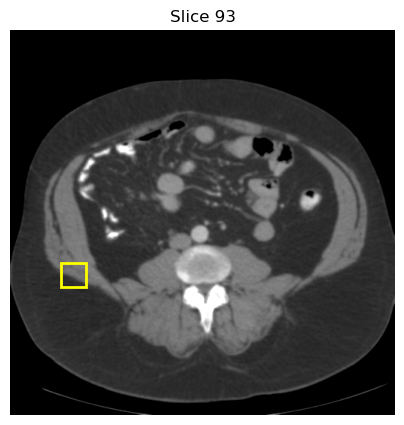

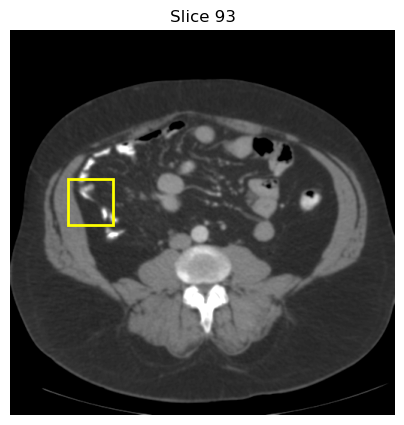

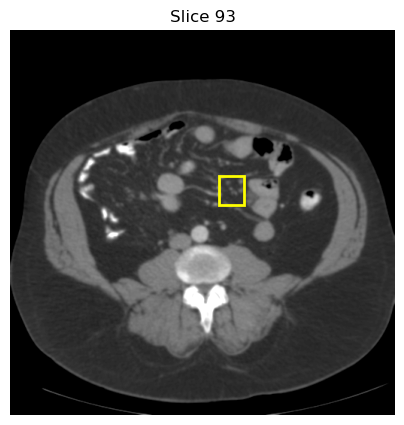

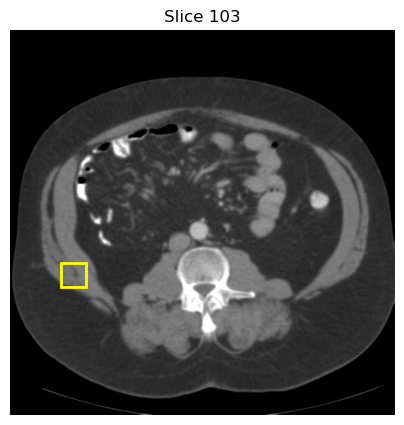

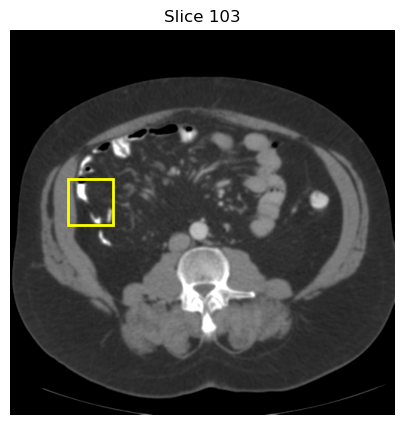

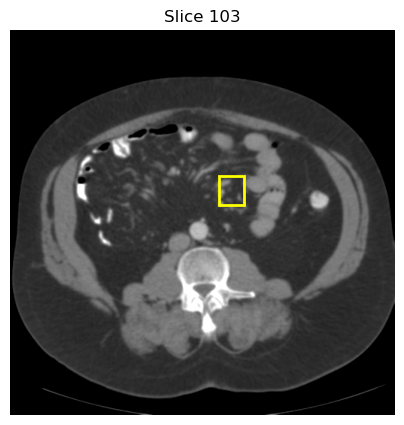

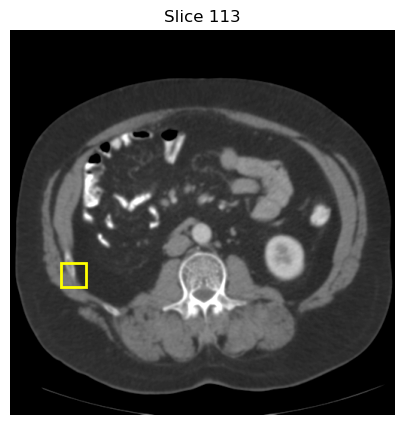

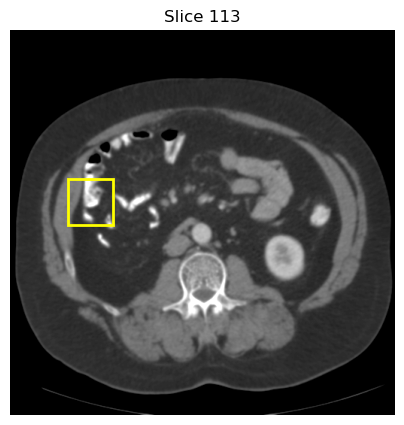

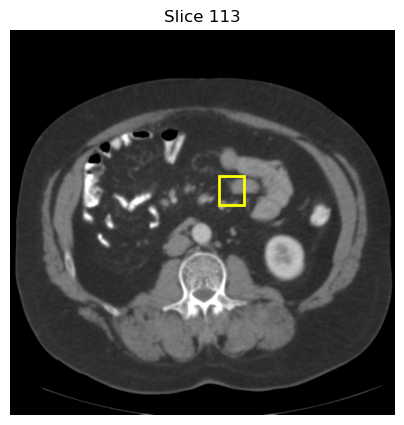


Mappe di errore (FP in rosso, FN in blu):


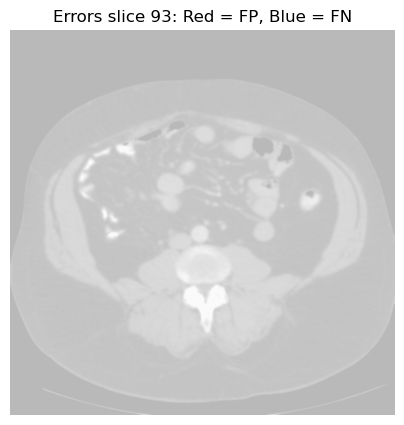

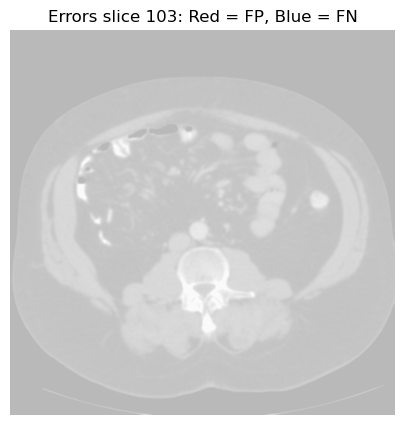

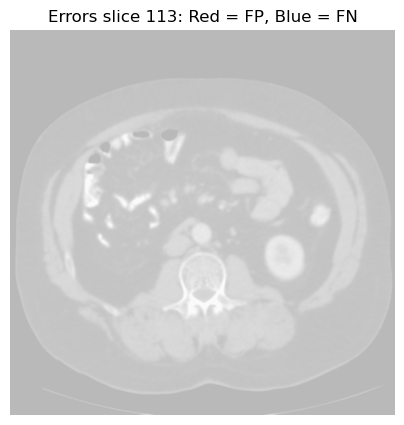

In [12]:
# --- Estrai auto_mask dai results ---
auto_union = np.zeros_like(ref_mask, dtype=np.uint8)
for res in results:
    auto_union |= res['final_mask']
auto_mask = auto_union

# --- Calcolo metriche su ref_vol/ref_mask ---
spacing = ref_ct.GetSpacing()
d   = EvalMetrics.dice     (ref_mask, auto_mask)
j   = EvalMetrics.jaccard  (ref_mask, auto_mask)
p   = EvalMetrics.precision(ref_mask, auto_mask)
r   = EvalMetrics.recall   (ref_mask, auto_mask)
hd  = EvalMetrics.hausdorff(ref_mask, auto_mask, spacing)
vd  = EvalMetrics.vol_diff (ref_mask, auto_mask, spacing)
assd_val = EvalMetrics.assd(ref_mask, auto_mask, spacing)
surf_dice = EvalMetrics.surface_dice(ref_mask, auto_mask, spacing, tol_mm=2.0)


print(f"Dice={d:.4f}, Jaccard={j:.4f}, Precision={p:.4f}, Recall={r:.4f}, Hausdorff={hd:.2f} mm, VolDiff={vd:.2f} cm³\n")
print(f"ASSD={assd_val:.2f} mm, SurfaceDice@2mm={surf_dice:.3f}")

# --- Overlay CT + GT + Auto sul ref_vol ---
mid = ref_vol.shape[0] // 2
for dz in [-10, 0, 10]:
    z = mid + dz
    if 0 <= z < ref_vol.shape[0]:
        for res in results:
            overlay_slice(
                ref_vol,                # ct
                ref_mask,               # ground truth
                auto_mask,              # predetta
                z,                      # indice di slice
                res['roi']              # il bbox di quella componente
            )

# --- Mappe di errore (FP/FN) sul ref_vol ---
print("\nMappe di errore (FP in rosso, FN in blu):")
for dz in [-10, 0, 10]:
    z = mid + dz
    if 0 <= z < ref_vol.shape[0]:
        overlay_errors(ref_vol, ref_mask, auto_mask, z)